    # Реализация метода нахождения ближайших соседей

#### Сначала нужно привести его в числовой вид

In [35]:
import numpy as np
import optuna
import pandas as pd
import sklearn.neighbors
from pandas import DataFrame

def updateCategoryColumnsToNumber(df: DataFrame, columns: list):
    for column in columns:
        values = df[column].unique()
        dict = {}
        for i in range(len(values)):
            if values[i] is not None:
                dict[values[i]] = i + 1
        df[column] = df[column].fillna(df[column].value_counts().idxmax())
        df[column] = df[column].map(dict).fillna(0)
    return df

def updateBooleanToInt(df: DataFrame, columns: list):
    for column in columns:
        df[column] = df[column].map({True: 1, False:0})
    return df

def changeZKH(x: str):
    if x == 'не включена':
        return 0
    else:
        new_x = x.split('(')[0][:-2].replace(' ', '')
        if new_x == 'включен':
            return np.NaN
        return int(new_x)
    
def updateComission(df: DataFrame, column: str):
    df[column] = df[column].fillna("0%").map(lambda x: int(x[:-1]))
    return df


def updateZKH(df: DataFrame, column: str):
    changedColumn = df[column].map(lambda x: changeZKH(x))
    df[column] = changedColumn.fillna(int(changedColumn.mean()))
    return df   

def updateFloat(df: DataFrame, columns: list):
    for column in columns:
        new_column = df[column].map(lambda x: float(str(x).replace(',','.')))
        df[column] = new_column.fillna(new_column.median())
    return df

df = pd.read_csv('flats.csv')

df = df.drop(columns=['Ссылка', 'Тип жилья', 'Аварийность', ])
df = updateCategoryColumnsToNumber(df, ['Город', 'Условия проживания', 'Срок аренды', 'Условия проживания', 'Предоплата', 'Метро', 'Парковка', 'Санузел', 'Вид из окон', 'Количество лифтов', 'Ремонт', 'Отопление', 'Газоснабжение', 'Мусоропровод', 'Тип дома', 'Тип перекрытий'])
df = updateBooleanToInt(df, ['Холодильник', 'Стиральная машина', 'Мебель в комнатах', 'Мебель на кухне', 'Телевизор', 'Интернет'])
df = updateZKH(df, 'Оплата ЖКХ')
df = updateComission(df, 'Комиссия')
df = updateFloat(df, ['Год постройки', 'Высота потолков', 'Общая площадь', 'Жилая площадь', 'Площадь кухни', 'Подъезды'])


{'Москва': 1, 'Санкт-Петербург': 2}


#### Теперь нормализуем min-max Scaler'ом

In [29]:
from sklearn.preprocessing import MinMaxScaler

norm_columns = ['Цена в месяц', 'Оплата ЖКХ', 'Комиссия', 'Залог', 'Общая площадь', 'Жилая площадь', 'Площадь кухни', 'Высота потолков']

X, y = df.drop(columns='Город'), df['Город']

# Нормализация
for column in norm_columns:
    if column in X.columns:
        X[column] = (X[column] - X[column].mean()) / X[column].std()

#### Сохраним всё в файл

In [32]:
# Save the modified DataFrame to a new CSV file
combined_df = pd.concat([y, X], axis=1)
combined_df.to_csv('flats_numeric.csv', index=False)
combined_df.shape

(2950, 31)

# Анализ получившихся данных

In [5]:
from matplotlib import pyplot as plt

percents = np.linspace(0, 1, 1000)
init_percentiles = df.describe(percents).tail(len(percents) + 3)
percentiles = X.describe(percents).tail(len(percents) + 3)
percentiles.shape

(1003, 30)

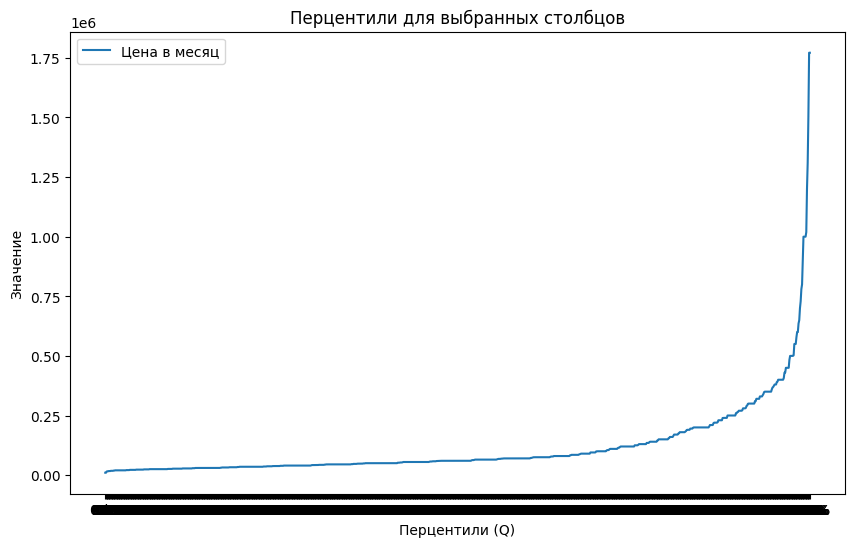

In [6]:

# Выберите столбцы, для которых хотите отобразить перцентили
columns_to_plot = ['Цена в месяц']  # Замените на нужные столбцы

# Создайте фигуру и оси
fig, ax = plt.subplots(figsize=(10, 6))

# Постройте линии перцентилей
for col in columns_to_plot:
    ax.plot(init_percentiles.index, init_percentiles[col], label=col)

# Добавьте метки и заголовок
ax.set_xlabel('Перцентили (Q)')
ax.set_ylabel('Значение')
ax.set_title('Перцентили для выбранных столбцов')
ax.legend()

# Отобразите график
plt.show()

## Adding config

In [7]:
class Distance:
    @staticmethod
    def minkowski(a: np.ndarray, b: np.ndarray, p):
        return (np.abs(a - b) ** p).sum(axis=-1) ** (1 / p)

    @staticmethod
    def euclidean(a, b):
        return Distance.minkowski(a, b, 2)

    @staticmethod
    def manhattan(a, b):
        return Distance.minkowski(a, b, 1)

    @staticmethod
    def cosine(a, b):
        return 1 - (a * b).sum(axis=-1) / np.linalg.norm(a, axis=-1) / np.linalg.norm(b, axis=-1)
    
    @staticmethod
    def getByName(name):
        if name == "euclidean":
            return Distance.euclidean
        elif name == "manhattan":
            return Distance.manhattan
        elif name == "cosine":
            return Distance.cosine

In [8]:
class Kernel:
    @staticmethod
    def uniform(u):
        u = np.abs(u)
        return (u < 1) / 2

    @staticmethod
    def common(u, a, b):
        u = np.abs(u)
        return (u < 1) * (1 - u ** a) ** b

    @staticmethod
    def triangular(u):
        return Kernel.common(u, 1, 1)

    @staticmethod
    def epanechnikov(u):
        return Kernel.common(u, 2, 1) * 0.75

    @staticmethod
    def gaussian(u):
        return 1 / np.sqrt(2 * np.pi) * np.exp(-(u ** 2) / 2)

    @staticmethod
    def cosine(u):
        u = np.abs(u)
        return np.pi / 4 * np.cos(np.pi / 2 * u) * (u < 1)
    
    @staticmethod
    def getByName(name):
        if name == "uniform":
            return Kernel.uniform
        elif name == "common":
            return Kernel.common
        elif name == "triangular":
            return Kernel.triangular
        elif name == "epanechnikov":
            return Kernel.epanechnikov
        elif name == "gaussian":
            return Kernel.gaussian
        elif name == "cosine":
            return Kernel.cosine

In [9]:
import json

class Config:
    def __init__(self, path):
        with open(path) as config_file:
            params = json.load(config_file)
            self.test_size = params["test_size"]
            self.optuna_size = params["optuna_size"]
            self.random_seed = params["random_seed"]
            self.radius = params["radius"]
            self.max_neighbour_count = params["max_neighbour_count"]
            self.n_trials = params["n_trials"]
            self.min_radius = params["min_radius"]

config: Config = Config('config.json')

## Разобьём данные на тренировочную и тестовые выборки

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config.test_size, random_state=config.random_seed)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2065, 30)
(2065,)
(885, 30)
(885,)


### Сделаем KNN модель, используя sklearn

In [13]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

class LibraryKNNClassifier:
    def __init__(self, metric_name, kernel_name, window_mode, k=None, radius=None):
        self.__metric = Distance.getByName(metric_name)
        self.__kernel = Kernel.getByName(kernel_name)
        self.__window_mode = window_mode
        self.__radius = radius
        self.__k = k
        
        if self.__window_mode == "neighbours":
            assert k is not None
            self.__model = KNeighborsClassifier(n_neighbors=self.__k + 1,weights=self.__weights, metric=self.__metric)
        elif self.__window_mode == "fixed":
            assert radius is not None
            self.__model = RadiusNeighborsClassifier(radius=self.__radius, weights=self.__weights, metric=self.__metric)
            
    def fit(self, X, y):
        self.__model.fit(X, y)
        
    def predict(self, X):
        return self.__model.predict(X)
 
    def __weights(self, distances):
        return np.array([self.get_weight(d) for d in distances])

    # distances - массив расстояний от объекта до ближайших вершин
    def get_weight(self, distances):
        distance_denominator = None
        if self.__window_mode == "neighbours":
            # print("distances.shape", distances.shape)
            # print("k", self.__k)
            distance_denominator = distances[self.__k]
        elif self.__window_mode == "fixed":
            # print("radius", self.__radius)
            distance_denominator = self.__radius
        # print("2distances.shape", distances.shape)
        # print("distance_denominator", distance_denominator)
        # print("(distance / distance_denominator).shape", (distances / distance_denominator).shape)
        return [self.__kernel(d) for d in (distances / distance_denominator)]
        

### Проверка

In [319]:
easy_X = np.array([
    [3, 3, 3],
    [-3, -3, -3],
    [-4, -4, -4],
    [-7, -7, -7],
    [2, 2, 2]
])
easy_y = np.array([1, 2, 2, 2, 1])

classifier = LibraryKNNClassifier('euclidean', 'triangular', "neighbours", k=2)
classifier.fit(easy_X, easy_y)
assert classifier.predict(np.array([[-5, -10, -3]])) == 2

## Сделаем свой KNN

In [14]:
class MyKNNClassifier:
    def __init__(self, metric_name, kernel_name, window_mode, k=None, radius=None):
        self.__metric = Distance.getByName(metric_name)
        self.__kernel = Kernel.getByName(kernel_name)
        self.__window_mode = window_mode
        self.__radius = radius
        self.__k = k
        if self.__window_mode == "neighbours":
            assert k is not None
        elif self.__window_mode == "fixed":
            assert radius is not None
            
    # 3-е это априорные веса
    def fit(self, X, y, weights=None):
        self.__X = X
        self.__y = y
        self.__weights = weights
    
    def predict(self, X):
        return np.array([self.mini_predict(x) for x in X])
    
    def mini_predict(self, x):
        distance_denominator: float = 0
        if self.__window_mode == "fixed":
            distance_denominator = self.__radius
        elif self.__window_mode == "neighbours":
            distances_from_x = [self.__metric(x, v) for v in self.__X]
            distances_from_x.sort()
            distance_denominator = distances_from_x[self.__k]
        
        classes_weights = {}
        for i in range(len(self.__y)):
            sample = self.__X[i]
            class_label = self.__y[i]
            aprior_weight = self.__weights[i] if self.__weights is not None else 1
            
            if class_label not in classes_weights:
                classes_weights[class_label] = 0
                
            distance: float = self.__metric(x, sample)
            classes_weights[class_label] += aprior_weight * self.__kernel(distance / distance_denominator)
        return max(classes_weights.keys(), key = classes_weights.get)

### Проверка  

In [291]:
classifier = MyKNNClassifier('euclidean', 'triangular', "neighbours", k=2)
classifier.fit(easy_X, easy_y)
assert classifier.predict(np.array([[-5, -10, -3]])) == 2

AttributeError: 'numpy.ndarray' object has no attribute 'iter_rows'

## Подбор гиперпараметров

#### Целевая функция качества

In [15]:
from sklearn.metrics import balanced_accuracy_score

def model_accuracy(y_real, y_predicted):
    return balanced_accuracy_score(y_real, y_predicted)

#### Перебор: метрики, ядра, тип окна, радиус, ширина окна

In [16]:
import optuna

def optimize(model_class, without_gaussian = False):
    def model_accuracy_objective(trial: optuna.Trial):
        choose = ["uniform", "triangular", "epanechnikov", "cosine"]
        if not without_gaussian:
            choose.append("gaussian")
        kernel_name = trial.suggest_categorical('kernel', choose)
        metric_name = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'cosine'])
        window_type = trial.suggest_categorical('window_type', ['neighbours', 'fixed'])
        
        k = None
        radius = None
        if window_type == "fixed":
            radius = trial.suggest_float('radius', config.min_radius, config.radius)
        else:
            k = trial.suggest_int('k', 1, X_train.shape[0] - 1)
            
        model = model_class(metric_name, kernel_name, window_type, k, radius)
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        
        return model_accuracy(y_test, predicted)
        
    model_study = optuna.create_study(direction='maximize')
    model_study.optimize(model_accuracy_objective, n_trials=config.n_trials)
    return model_study.best_params

## Получим лучшие параметры

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2065, 30)
(2065,)
(885, 30)
(885,)


In [281]:
library_model_params = optimize(LibraryKNNClassifier, True)
library_model_params

[I 2024-09-12 00:02:33,893] A new study created in memory with name: no-name-a3358f50-c7ca-4d89-b906-a69f15b0ea9f
[I 2024-09-12 00:02:53,132] Trial 0 finished with value: 0.9281683229051649 and parameters: {'kernel': 'cosine', 'metric': 'cosine', 'window_type': 'neighbours', 'k': 62}. Best is trial 0 with value: 0.9281683229051649.
[I 2024-09-12 00:03:12,430] Trial 1 finished with value: 0.9270028217396638 and parameters: {'kernel': 'epanechnikov', 'metric': 'cosine', 'window_type': 'neighbours', 'k': 61}. Best is trial 0 with value: 0.9281683229051649.
[I 2024-09-12 00:03:20,922] Trial 2 finished with value: 0.8899981597350018 and parameters: {'kernel': 'cosine', 'metric': 'euclidean', 'window_type': 'neighbours', 'k': 275}. Best is trial 0 with value: 0.9281683229051649.
[I 2024-09-12 00:03:44,643] Trial 3 finished with value: 0.8496810207336523 and parameters: {'kernel': 'triangular', 'metric': 'cosine', 'window_type': 'neighbours', 'k': 1893}. Best is trial 0 with value: 0.92816832

{'kernel': 'epanechnikov',
 'metric': 'manhattan',
 'window_type': 'neighbours',
 'k': 9}

In [294]:
my_model_params = optimize(MyKNNClassifier)
print(my_model_params)

[I 2024-09-12 00:41:40,254] A new study created in memory with name: no-name-f9f989f8-6b49-497e-b811-b0dc6c8a6d92
[I 2024-09-12 00:42:04,977] Trial 0 finished with value: 0.5 and parameters: {'kernel': 'triangular', 'metric': 'cosine', 'window_type': 'fixed', 'radius': 1587.293989680778}. Best is trial 0 with value: 0.5.
[I 2024-09-12 00:42:47,977] Trial 1 finished with value: 0.8460464973622868 and parameters: {'kernel': 'epanechnikov', 'metric': 'cosine', 'window_type': 'neighbours', 'k': 1876}. Best is trial 1 with value: 0.8460464973622868.
[I 2024-09-12 00:43:00,038] Trial 2 finished with value: 0.5 and parameters: {'kernel': 'cosine', 'metric': 'euclidean', 'window_type': 'fixed', 'radius': 1829.9090955699044}. Best is trial 1 with value: 0.8460464973622868.
[I 2024-09-12 00:43:42,914] Trial 3 finished with value: 0.8865016562384984 and parameters: {'kernel': 'uniform', 'metric': 'cosine', 'window_type': 'neighbours', 'k': 231}. Best is trial 3 with value: 0.8865016562384984.
[I 

{'kernel': 'epanechnikov', 'metric': 'manhattan', 'window_type': 'neighbours', 'k': 9}


In [18]:
# Лучшие значения совпали
best_kernel = 'epanechnikov'
best_metric = 'manhattan'
best_window_type = 'neighbours'
best_k = 9

Построим график зависимостей

In [19]:
import matplotlib.pyplot as plt

k_values = list(range(1, 30))
print(len(k_values))
len(k_values)

def get_model_results(model_class, ds_x, ds_y):
    res = []
    for k in k_values:
        model = model_class(best_metric, best_kernel, best_window_type, k)
        model.fit(X_train, y_train)
        acc = model_accuracy(ds_y, model.predict(ds_x))
        res.append(acc)
    return res    

def plot_accuracy(model_class):
    train_results = get_model_results(model_class, X_train, y_train)
    test_results = get_model_results(model_class, X_test, y_test)
    
    plt.plot(k_values, train_results, label='train')
    plt.plot(k_values, test_results, label='test')
    plt.xlabel('k - кол-во соседей')
    plt.ylabel('качество')
    plt.legend()
    plt.show()


29


/tmp/ipykernel_233193/239529210.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  classes_weights[class_label] += aprior_weight * self.__kernel(distance / distance_denominator)
/tmp/ipykernel_233193/3548048841.py:10: RuntimeWarning: invalid value encountered in multiply
  return (u < 1) * (1 - u ** a) ** b
/tmp/ipykernel_233193/239529210.py:41: RuntimeWarning: invalid value encountered in scalar divide
  classes_weights[class_label] += aprior_weight * self.__kernel(distance / distance_denominator)


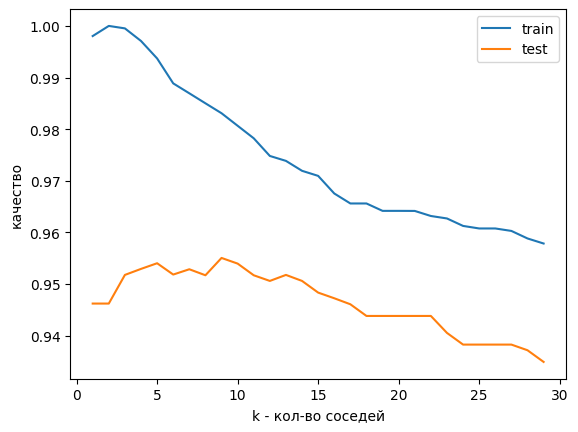

In [332]:
plot_accuracy(MyKNNClassifier)

/tmp/ipykernel_233193/2251356129.py:38: RuntimeWarning: invalid value encountered in divide
  return [self.__kernel(d) for d in (distances / distance_denominator)]


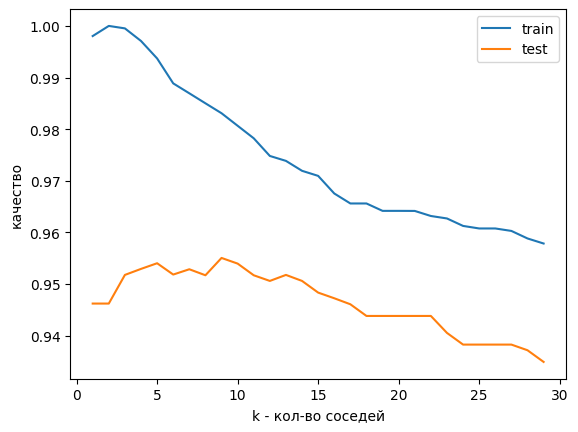

In [333]:
plot_accuracy(LibraryKNNClassifier)

### Поиск аномалий LOWESS

Тут на самом деле ядра для lowess неитересные (кроме gauss ядра), потому что тут задача бинарной классификации, которая при угаданному предикшену будет давать будет давать вес 1, а при не угаданном - вес 0.  
Но гаусово - ядро интереснее (потому что при 0 даёт вёс - не 1; а при 1 - даёт вес не 0), правда им воспользоваться не получиться для LibraryKNN, поэтому мы сделаем так -> применим lowess на моём KNN с гауссовым ядром. А далее сравним на ядре Епанечникове оба алгоритма



In [25]:
def lowess_weights(model, kernel):
    weights = []
    for i in range(X_train.shape[0]):
        X_train_curr = np.delete(X_train, (i), axis=0)
        y_train_curr = np.delete(y_train, (i), axis=0)
        model.fit(X_train_curr, y_train_curr)
        prediction = model.predict(np.array([X_train[i]]))[0]
        arg = 0 if y_train[i] == prediction else 1
        weights.append(kernel(arg))
    return np.array(weights)

In [ ]:
my_model = MyKNNClassifier(best_metric, best_kernel, best_window_type, best_k)
my_model_weights = lowess_weights(my_model, Kernel.gaussian)

my_model_weights[0]

До 0.9550361918782971
После 0.9449607410133726


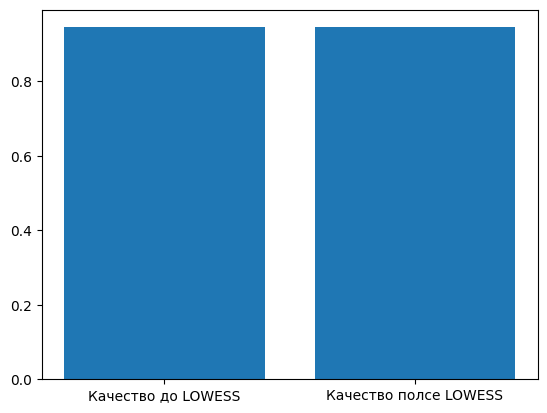

In [22]:
my_model.fit(X_train, y_train)
original_acc = model_accuracy(y_test, my_model.predict(X_test))
my_model.fit(X_train, y_train, weights=my_model_weights)
acc_weights = model_accuracy(y_test, my_model.predict(X_test))

print('До', original_acc)
print('После', acc_weights)

plt.bar(['Качество до LOWESS', 'Качество полсе LOWESS'], acc_weights)
plt.show()

Как видим, acc стал ниже, я предполагаю, что так произошло, потому что суть моей классификации - определить в каком городе - происходит аренда. Москва или Питер, и макс. коррелирующие в этом случае признаки - будут кол-во квадратов и стоимость квартиры. LOWESS - по сути в этом случае с помощью Ядра Гаусса - "усредняет" все веса. Хотя по факту между ними действительно значительная разница в весе. На тесте - из-за этого падает скор. 

## А теперь сравним MyKNN и LibraryKNN

In [26]:
my_model = MyKNNClassifier(best_metric, best_kernel, best_window_type, best_k)

my_model.fit(X_train, y_train)
acc1 = model_accuracy(y_test, my_model.predict(X_test))
my_model.fit(X_train, y_train, weights=lowess_weights(my_model, Kernel.epanechnikov))
acc2 = model_accuracy(y_test, my_model.predict(X_test))

print('Улучшение с LOWESS', acc2 - acc1)

Улучшение с LOWESS -0.013433934486566046


In [27]:
library_model = LibraryKNNClassifier(best_metric, best_kernel, best_window_type, best_k)

library_weights = lowess_weights(library_model, Kernel.epanechnikov)
library_model.fit(X_train, y_train)
acc1 = model_accuracy(y_test, library_model.predict(X_test))
X_train_curr = X_train[library_weights != 0]
y_train_curr = y_train[library_weights != 0]
library_model.fit(X_train_curr, y_train_curr)
acc2 = model_accuracy(y_test, library_model.predict(X_test))

print('Улучшение с LOWESS', acc2 - acc1)

Улучшение с LOWESS -0.01233744325849584


Как я и сказал, кажется, что особенность тестовых данных дала такой результат